**Poojitha Konduparti**

## Picking a Movie using the Multi Armed Bandit Problem

**What is the Multi Armed Bandit Problem?**

Multi Armed Bandit Problem is set in the premise that there is a gambler in a casino with some number of slot machines(a bandit) and the goal is to maximize the profits by playing the machines.

Here, the need for the problem arises that the gambler does not already know the most profitable slot machine, it wouldn't be a gamble if they already did! How would the gambler know which machine to play and for how many times, for him/her to achieve maximum reward?

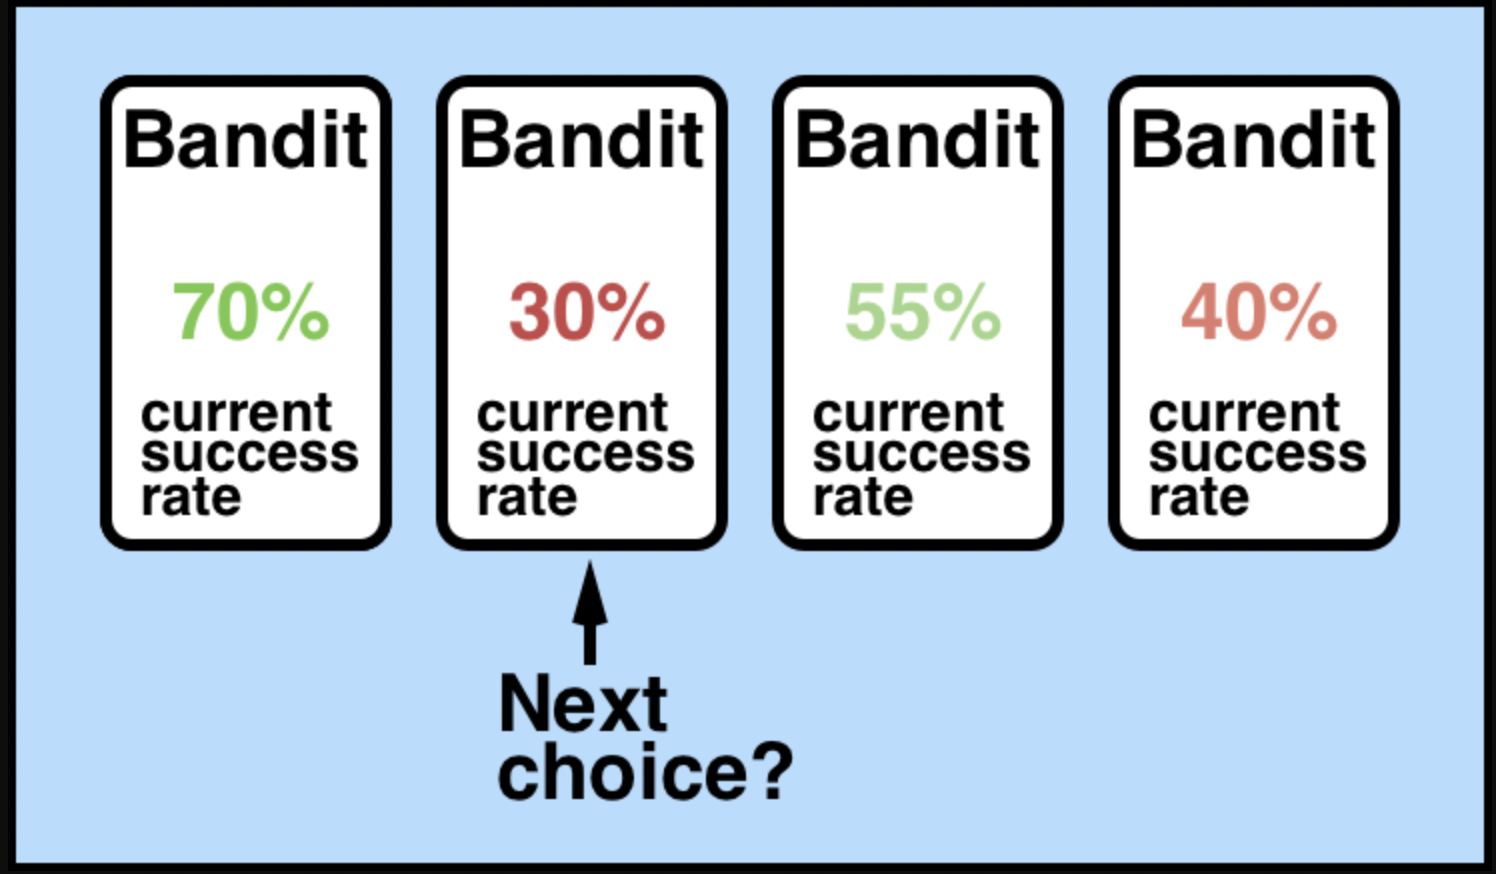












**Picking a Movie using the MAB Problem**

Multi Armed Bandits are used in several scenarios, like picking a movie, choosing a restaurant, choosing courses, etc. 
we will be talking about choosing a movie based on the likelihood of them being picked by a user.




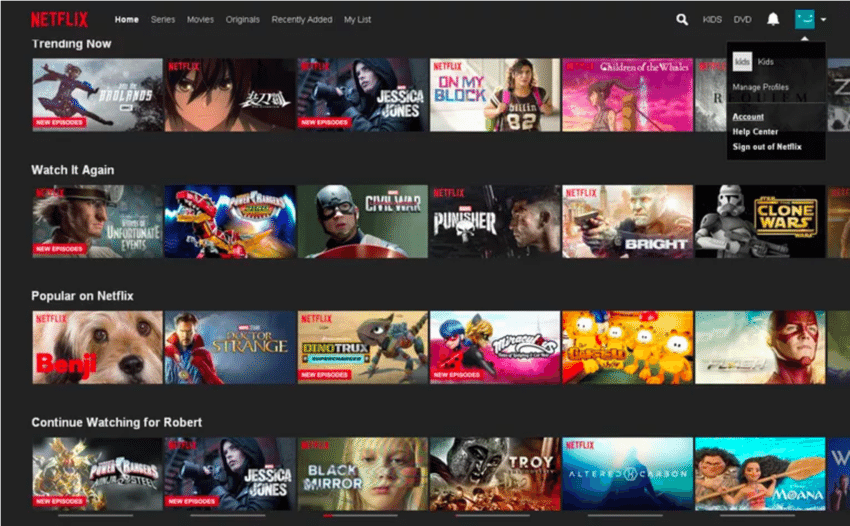

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pdb import set_trace


In [57]:
stationary=True
class Movies():
  def __init__(self, movie_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.movie_count = movie_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.movie_count)
  
  def get_reward_regret(self, movie):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.movie_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[movie]
    regret = self.thetas.max() - self.thetas[movie]
    
    return reward, regret

## Thompson Sampling

The idea that is used the most in the MAB problem, is to solve the problem of the **exploration-exploitation** trade off. One needs to know how many options to explore before choosing the best option.

It is a very common occurrence that we browse through netflix and hbo max, hulu for hours in search for a movie and end up not watching anything. How long do we browse for before we end up choosing a movie which will bring us the maximum amount of satisfaction? This is known as the **exploration-exploitation** problem.

Thompson Sampling aims to deal with this problem based on uncertainty and quality. Let's assume that there's a list of 10 movies where 3 of them are the ones that we already watched, and 2 of them belong to horror genre and 2 of them to crime thriller and 2 belong to comedy and 1 belongs to comedy and all of these movies are assigned a mean reward.  

In Thompson Sampling, we explore by incorporating uncertainty by modelling Bernouilli parameter with a prior beta distribution.




In [58]:
class Thompson():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.movie_count = bandit.movie_count
    self.a = np.ones(self.movie_count)
    self.b = np.ones(self.movie_count)
  
  def get_reward_regret(self, movie):
    reward, regret = self.bandit.get_reward_regret(movie)
    self.update_parameters(movie, reward)
    return reward, regret
  
  def update_parameters(self, movie, reward):
    self.a[movie] += reward
    self.b[movie] += 1 - reward


 
    
    
    
        

In [59]:
class ThompsonBernouilli(Thompson):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.a, self.b)
    return theta.argmax()
    

In [60]:
class ThompsonNonBeta():
    def __init__(self, bandit):
        self.bandit = bandit
        self.movie_count = bandit.movie_count
        self.a = np.ones(self.movie_count)
        self.b = np.ones(self.movie_count)
        self.mu = np.ones(self.movie_count)
        self.sigma = np.ones(self.movie_count)
  
    def get_reward_regret(self, movie):
        reward, regret = self.bandit.get_reward_regret(movie)
        self.update_parameters(movie, reward)
        return reward, regret
  
    def update_parameters(self, movie, reward):
        self.a[movie] += reward
        self.b[movie] += 1 - reward
        self.mu = self.a / (self.a + self.b)
        self.sigma = (self.a * self.b)/((self.a + self.b)**2 * (self.a + self.b +1))

    @staticmethod
    def name():
        return 'thompson-normal'
  
    def get_action(self):
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()

In [61]:
def normal_thompson_experiment(movie_count, timesteps = 1000, simulations=1000):
    algos = [EpsilonGreedy, UCB, ThompsonBernouilli,RandomSampling,ThompsonNonBeta]
    regrets = []
    names = []
    for algo in algos:
        regrets.append(simulate(simulations, timesteps, movie_count, algo))
        names.append(algo.name())
    multi_plot_data(regrets, names)
    

In [62]:
class RandomSampling():
    def __init__(self, bandit):
        self.bandit = bandit
        self.movie_count = bandit.movie_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        """ Generating random samples between 0 and 1 using uniform distribution"""
        theta = np.random.uniform(0,1,self.movie_count)
        return theta.argmax()
    
    def get_reward_regret(self, movie):
        reward, regret = self.bandit.get_reward_regret(movie)
        return reward, regret


## Epsilon Greedy

The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

In [70]:
epsilon = 0.1
class EpsilonGreedy():
  
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.movie_count = bandit.movie_count
    self.Q = np.zeros(self.movie_count) # q-value of actions
    self.N = np.zeros(self.movie_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.movie_count)
    return action
  
  def get_reward_regret(self, movie):
    reward, regret = self.bandit.get_reward_regret(movie)
    self.update_parameters(movie, reward)
    return reward, regret
  
  def update_parameters(self, movie, reward):
    self.N[movie] += 1 # increment action count
    self.Q[movie] += 1/self.N[movie] * (reward - self.Q[movie]) # inc. update rule
    
    

    
    

## Upper Confidence Bound

 UCB algorithm assumes they all have the same observed average value. Then the algorithm creates a confidence bound for each arm or movie.
 
So it randomly picks any of the arms or ads. Then two things can happen- the user clicks the ad or the arm gives a reward or does not. Let’s say the movie did not have a click or the arm was a failure.

So the observed average of the ad or arm will go down. And the confidence bound will also go down. 

If it had a click, the observed average would go up and the confidence bound also go up. By exploiting the best one we are decreasing the confidence bound. As we are adding more and more samples, the probability of other arms or ads doing well is also going up. This is the fundamental concept of UCB.



In [64]:
ucb_c = 2
class UCB():
  
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.movie_count = bandit.movie_count
    self.Q = np.zeros(self.movie_count) # q-value of actions
    self.N = np.zeros(self.movie_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.movie_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, movie):
    reward, regret = self.bandit.get_reward_regret(movie)
    self.update_parameters(movie, reward)
    return reward, regret
  
  def update_parameters(self, movie, reward):
    self.N[movie] += 1 # increment action count
    self.Q[movie] += 1/self.N[movie] * (reward - self.Q[movie]) # inc. update rule

In [65]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  

In [66]:
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()

In [67]:
 def simulate(simulations, timesteps, movie_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Movies(movie_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

In [68]:
def experiment(movie_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, ThompsonBernouilli,RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, movie_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

### Q1. Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important

In **Thompson Sampling**, alpha and beta from the beta distribution are the hyperparameters that are essential to Thompson sampling.As the values of alpha and beta are chosen at random, we can only regulate the number of iterations.

For the **epsilon greedy** algorithm,the value of epsilon determines the total number of explorations. Which makes it the important hyperparameter.

For **UCB**, the important hyperparameter is the constant c in the below equation.

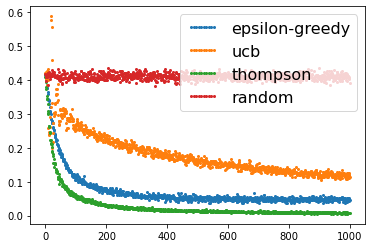

In [69]:
# Experiment 1
movie_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(movie_count)

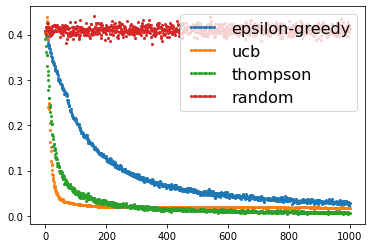

In [71]:
# Experiment 2
movie_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(movie_count)

### Q2. How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why

To assess the impact of a larger action space, we increase the number of movies from 10 to 300 while keeping the baseline model's values the same for the other parameters. 

The **e-greedy** agent seems to have not changed a lot in its learning in comparison to the baseline. We can conclude that the action space does not impact the e greedy algorithm by a lot.

On the other hand, the **Thompson** agent proves to be the better one in comparison to the e-greedy algorithm when given a larger action space.


The **UCB** agent is highly unstable in the large action space, although we can't attribute this performance solely to the action space. The reward probabilities are closer to each other in this scenario which affects the regret.


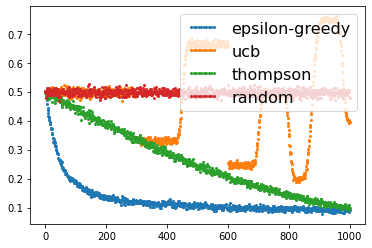

In [72]:
# Experiment 3
movie_count = 300 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(movie_count)

### Q3. How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling?

Our baseline model had a stationary state and we will now try to experiment with a non-stationary environment.

The bernouilli parameters are resampled after every 100 parameters. The true reward distribution evolves over time, the only way to do well in this scenario would be to give priority to exploration. 

The **e-greedy and Thompson's** regret quickly decrease but on an average they increase over time.  

**UCB** responds to the non-stationary environment quickly and shows consistent improvement in regret over time. 

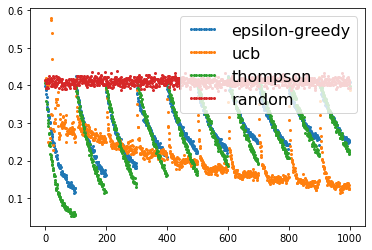

In [73]:
# Experiment 4
movie_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(movie_count)

### Q4. When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff

**Thompson** sampling clearly performs much better than the other models because it explores efficiently by discarding the arms with lesser long term rewards. 

**UCB** chooses the movie(arm) which has the highest value at the upper bound to maintain the balance between exploration exploitation. 



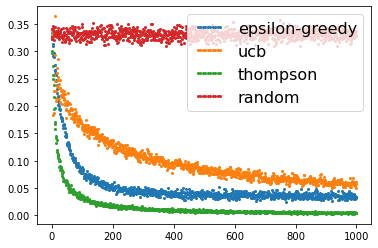

In [74]:
# Experiment 5
movie_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(movie_count)

### Q5. How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.


The probabilities of success are not known to the agent. One of the ways that we can learn is by testing.In order to achieve more successes, the regrets should be decreasing.

The **Thompson** agent converges and the regret value reaches 0 after 300 timesteps

The **E greedy** model's progress is hard to monitor after a while because the regret stays between 0-0.1.


**UCB** on the other hand quite gradually reduces the regret. The exploiting begins after 400 timesteps of exploration.



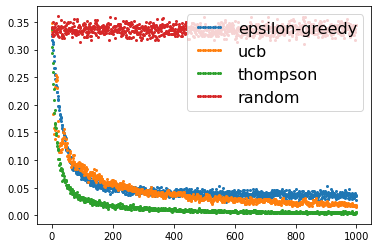

In [75]:
# Experiment 6
movie_count = 5 # number of arms in bandit
epsilon = 0.1
ucb_c = 1
stationary=True
experiment(movie_count)

### Q6. Thompson Sampling with non-Beta distribution? Modify the Thompson Sampling to run with a Different Distritbution?

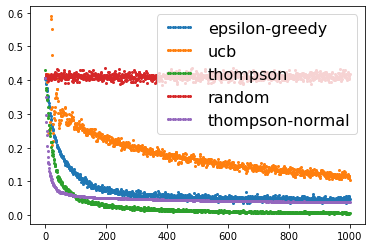

In [55]:
movie_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
normal_thompson_experiment(movie_count)

### Q7. What code is yours and what have you adapted?

I have used the following sources for the code and explanations and for conceptual clarity and research.

I have changed the parameters to suit my use-case scenario of picking a movie and experimented it with my own values that deem fit to the use case.



**References:**


[1] https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb


[2] https://colab.research.google.com/drive/1R5QiVlF6w08dyQmTE6AoBi-TfjOoXcSk#scrollTo=8HDhqWdzi2oD


[3] https://www.optimizely.com/optimization-glossary/multi-armed-bandit/


[4] https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf


[5] https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/#:~:text=Epsilon%2DGreedy%20is%20a%20simple,a%20small%20chance%20of%20exploring.

[6] http://www.sefidian.com/2019/12/07/upper-confidence-bound-ucb-algorithm-explained/



### Q8. Did I explain my licensing clearly?

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Copyright (c) Poojitha Konduparti


Distributed under MIT License